In [1]:
import requests, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
api_key = "PUT YOUR NASA API KEY"
api_url = 'https://api.nasa.gov/mars-photos/api/v1/rovers/'

In [3]:
def get_rover_data():
    r = requests.get(api_url + '?api_key=' + api_key)
    data = r.json()
    #print(r.headers)    to check remaining calls to api
    return data

def get_photos(rover, sol, camera):
    sol_pic = False
    retry_count = 0
    while not sol_pic:
        r = requests.get(api_url + rover + '/photos?sol=' + str(sol) + '&camera=' + camera + '&api_key=' + api_key)
        if r.status_code != 200:
            print(f"Error {r.status_code} while fetching photos for rover {rover} on Sol {sol} with camera {camera}")
            return []
        data = r.json()
        
        if data['photos'] or retry_count > 2:
            sol_pic = True
        else:
            sol -= 1
            retry_count += 1
    return data['photos']

def download_photos(camera_data, camera_name, path):
    img_data = requests.get(camera_data[len(camera_data) - 1]['img_src']).content
    with open(path + camera_name + '.jpg', 'wb') as handler:
        handler.write(img_data)

def main():
    rover_data = get_rover_data()
    path = 'images/'
    if not os.path.exists(path):
        os.makedirs(path)
    
    for rover in rover_data['rovers']:
        if (rover['status'] == 'complete'):
            continue
        path = 'images/' + rover['name'] + '/'
        if not os.path.exists(path):
            os.makedirs(path)
        print(f"Scraping rover {rover['name']}, starting with Sol {rover['max_sol']} ({rover['max_date']}) (rover status: {rover['status']})")
        for camera in rover['cameras']:
            print(f"Scraping camera {rover['name']}@{camera['name']} ({camera['full_name']})")
            camera_data = get_photos(rover['name'], rover['max_sol'], camera['name'])
            if not camera_data:
                continue
            download_photos(camera_data, camera['name'], path)

In [4]:
main()

Scraping rover Curiosity, starting with Sol 4102 (2024-02-19) (rover status: active)
Scraping camera Curiosity@FHAZ (Front Hazard Avoidance Camera)
Scraping camera Curiosity@NAVCAM (Navigation Camera)
Scraping camera Curiosity@MAST (Mast Camera)
Scraping camera Curiosity@CHEMCAM (Chemistry and Camera Complex)
Scraping camera Curiosity@MAHLI (Mars Hand Lens Imager)
Scraping camera Curiosity@MARDI (Mars Descent Imager)
Scraping camera Curiosity@RHAZ (Rear Hazard Avoidance Camera)
Scraping rover Perseverance, starting with Sol 1140 (2024-05-04) (rover status: active)
Scraping camera Perseverance@EDL_RUCAM (Rover Up-Look Camera)
Scraping camera Perseverance@EDL_DDCAM (Descent Stage Down-Look Camera)
Scraping camera Perseverance@EDL_PUCAM1 (Parachute Up-Look Camera A)
Scraping camera Perseverance@EDL_PUCAM2 (Parachute Up-Look Camera B)
Scraping camera Perseverance@NAVCAM_LEFT (Navigation Camera - Left)
Scraping camera Perseverance@NAVCAM_RIGHT (Navigation Camera - Right)
Scraping camera Per

In [5]:
rovers_data = get_rover_data()

In [6]:
rovers_data = rovers_data["rovers"]
rovers_data

[{'id': 5,
  'name': 'Curiosity',
  'landing_date': '2012-08-06',
  'launch_date': '2011-11-26',
  'status': 'active',
  'max_sol': 4102,
  'max_date': '2024-02-19',
  'total_photos': 695670,
  'cameras': [{'name': 'FHAZ', 'full_name': 'Front Hazard Avoidance Camera'},
   {'name': 'NAVCAM', 'full_name': 'Navigation Camera'},
   {'name': 'MAST', 'full_name': 'Mast Camera'},
   {'name': 'CHEMCAM', 'full_name': 'Chemistry and Camera Complex'},
   {'name': 'MAHLI', 'full_name': 'Mars Hand Lens Imager'},
   {'name': 'MARDI', 'full_name': 'Mars Descent Imager'},
   {'name': 'RHAZ', 'full_name': 'Rear Hazard Avoidance Camera'}]},
 {'id': 7,
  'name': 'Spirit',
  'landing_date': '2004-01-04',
  'launch_date': '2003-06-10',
  'status': 'complete',
  'max_sol': 2208,
  'max_date': '2010-03-21',
  'total_photos': 124550,
  'cameras': [{'name': 'FHAZ', 'full_name': 'Front Hazard Avoidance Camera'},
   {'name': 'NAVCAM', 'full_name': 'Navigation Camera'},
   {'name': 'PANCAM', 'full_name': 'Panoram

In [7]:
df = pd.DataFrame.from_dict(rovers_data)
df

,id,name,landing_date,launch_date,status,max_sol,max_date,total_photos,cameras
0,5,Curiosity,2012-08-06,2011-11-26,active,4102,2024-02-19,695670,"[{'name': 'FHAZ', 'full_name': 'Front Hazard A..."
1,7,Spirit,2004-01-04,2003-06-10,complete,2208,2010-03-21,124550,"[{'name': 'FHAZ', 'full_name': 'Front Hazard A..."
2,6,Opportunity,2004-01-25,2003-07-07,complete,5111,2018-06-11,198439,"[{'name': 'FHAZ', 'full_name': 'Front Hazard A..."
3,8,Perseverance,2021-02-18,2020-07-30,active,1140,2024-05-04,216548,"[{'name': 'EDL_RUCAM', 'full_name': 'Rover Up-..."


In [8]:
df = df.set_index("id")

In [9]:
df["cameras"] = len(df["cameras"])

In [10]:
df = df.rename(columns={
    "name": "Name",
    "landing_date": "Landing Date",
    "launch_date": "Launch Date",
    "status": "Status",
    "max_sol": "Last Picture Sol",
    "max_date": "Last Picture Date",
    "total_photos": "Total Photos",
    "cameras": "Cameras"
})

In [11]:
df = df.sort_values(by=["Launch Date", "Status"], ascending=[False, True])
df

,Name,Landing Date,Launch Date,Status,Last Picture Sol,Last Picture Date,Total Photos,Cameras
id,,,,,,,,
8,Perseverance,2021-02-18,2020-07-30,active,1140,2024-05-04,216548,4
5,Curiosity,2012-08-06,2011-11-26,active,4102,2024-02-19,695670,4
6,Opportunity,2004-01-25,2003-07-07,complete,5111,2018-06-11,198439,4
7,Spirit,2004-01-04,2003-06-10,complete,2208,2010-03-21,124550,4


In [12]:
df["Landing Date"] = df["Landing Date"].astype("datetime64[ns]")
df["Launch Date"] = df["Launch Date"].astype("datetime64[ns]")
df["Last Picture Date"] = df["Last Picture Date"].astype("datetime64[ns]")

In [13]:
df['Travel Time M'] = ((df['Landing Date'] - df['Launch Date']) / pd.Timedelta(days=30)).astype("int")

In [14]:
df = df[["Name", "Status", "Landing Date", "Launch Date", "Travel Time M", "Last Picture Sol", "Last Picture Date", "Total Photos", "Cameras"]]

In [15]:
styled_df = df.style.format({'Landing Date': '{:%Y-%m-%d}', 'Launch Date': '{:%Y-%m-%d}', "Last Picture Date": "{:%Y-%m-%d}"})
styled_df = styled_df.set_table_styles([{'selector': 'td', 'props': [('text-align', 'center'), ('padding', '1em')]}])
styled_df

,Name,Status,Landing Date,Launch Date,Travel Time M,Last Picture Sol,Last Picture Date,Total Photos,Cameras
id,,,,,,,,,
8,Perseverance,active,2021-02-18,2020-07-30,6,1140,2024-05-04,216548,4
5,Curiosity,active,2012-08-06,2011-11-26,8,4102,2024-02-19,695670,4
6,Opportunity,complete,2004-01-25,2003-07-07,6,5111,2018-06-11,198439,4
7,Spirit,complete,2004-01-04,2003-06-10,6,2208,2010-03-21,124550,4


In [16]:
df_for_table = df.copy()
df_for_table['Landing Date'] = df['Landing Date'].dt.strftime('%Y-%m-%d')
df_for_table['Launch Date'] = df['Launch Date'].dt.strftime('%Y-%m-%d')
df_for_table['Last Picture Date'] = df['Last Picture Date'].dt.strftime('%Y-%m-%d')

[['Perseverance', 'active', '2021-02-18', '2020-07-30', 6, 1140, '2024-05-04', 216548, 4], ['Curiosity', 'active', '2012-08-06', '2011-11-26', 8, 4102, '2024-02-19', 695670, 4], ['Opportunity', 'complete', '2004-01-25', '2003-07-07', 6, 5111, '2018-06-11', 198439, 4], ['Spirit', 'complete', '2004-01-04', '2003-06-10', 6, 2208, '2010-03-21', 124550, 4]]


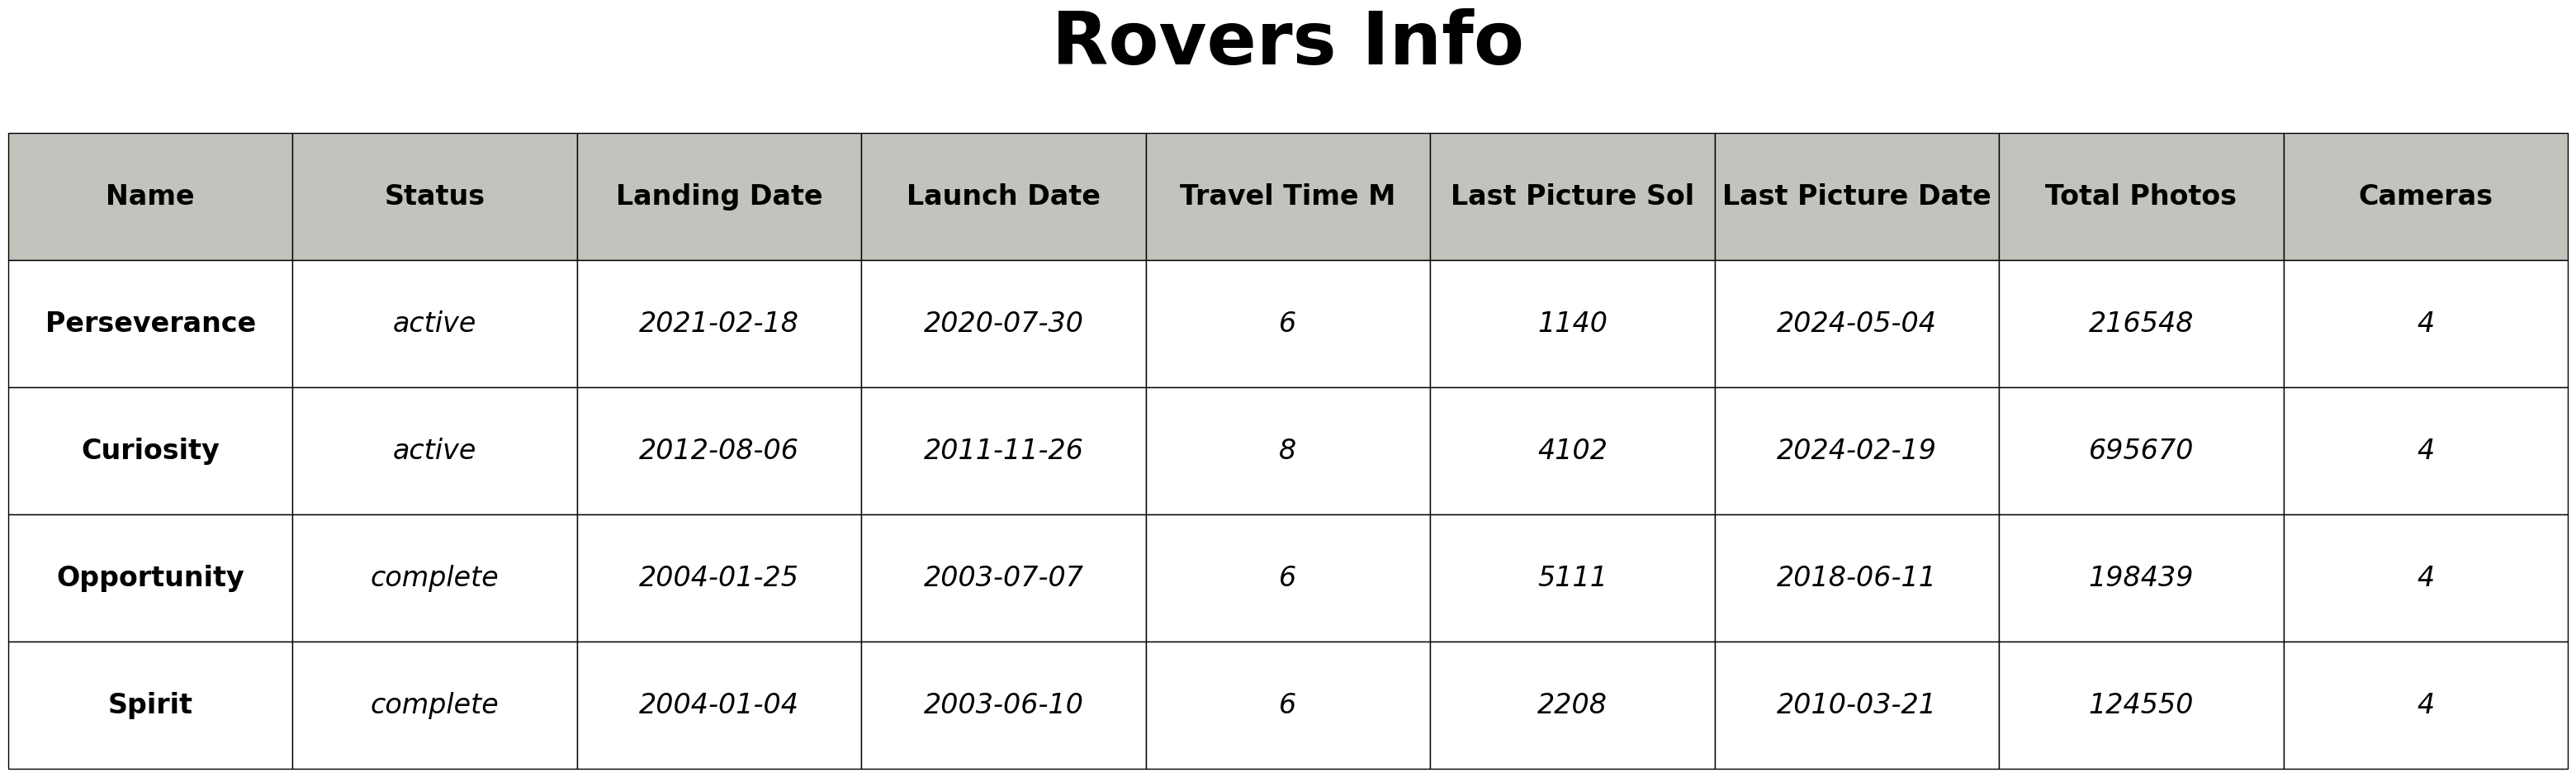

In [37]:
fig, ax = plt.subplots(figsize=(40, 10))

data = df_for_table.values.tolist()

table = ax.table(cellText=data,
                 loc='center',
                 colLabels=df_for_table.columns,
                 bbox=[0, 0, 1, 1],
                 cellLoc='center',
                 colColours =["#C3C2BC"] * 10,
                )

for (i, j), cell in table.get_celld().items():
    if i == 0 or j == 0:
        cell.set_text_props(fontweight="bold")
    else:
        cell.set_text_props(fontstyle="italic")

ax.set_title('Rovers Info', 
             fontweight="bold",
             fontsize="64",
             pad=60
            ) 

table.auto_set_font_size(False)
table.set_fontsize(24)
table.scale(2, 2)

ax.axis('off')

plt.savefig('rovers_info_table.png', bbox_inches='tight', pad_inches=0.5)
plt.show()